Jupyter notebook for doing the interview task for UMC:

**Analyse the drug side-effect reports (def:_narratives_)**

- look at differences between COVID and non-COVID cases
- what can we say about the text?
- suggestions in assignment:
    - first person? why?
    - redundant narrative? why?
- self investigations
    - text lengths and distributions wrt cases -- classifier. Histogram as feature for a Naive Bayes
        - Statistics
    - What features make it first person?
        - Statistics
    - redundancy detection:
        - duplication detection regexp within narrative
        - duplication of information from other columns and data files?
        - fluff content vs. entropy content
    - vocabulary differences: word frequency distributions TF-IDF 
    - content itself: keywords?
    - timing of narrative wrt symptoms?
    - look at all possibilities and their relevant narratives: FN, FP, TP, TN
    - *Sentiment analysis:* TextBlob, Vader, LLM?
    - *Topic models with LDA*


In [1]:
import pickle
import pandas as pd
from IPython.display import display
import numpy as np

data_filename = "2020VAERSDATA"
vax_filename = "2020VAERSVAX"
symptoms_filename = "2020VAERSSYMPTOMS"

Read in data and display relevant columns 

In [2]:
read_full_data_FLAG = False
# ---
if read_full_data_FLAG:
    with open(data_filename+".pickle", 'rb') as fh:
        df_data, cols_data = pickle.load(fh)
        display(df_data[cols_data].head(5))
    print("\n\n")
    with open(vax_filename+".pickle", 'rb') as fh:
        df_vax, cols_vax = pickle.load(fh)
        display(df_vax[cols_vax].head(5))
    print("\n\n")
    with open(symptoms_filename+".pickle", 'rb') as fh:
        df_symptoms, cols_symptoms = pickle.load(fh)
        display(df_symptoms[cols_symptoms].head(5))
else:
    with open("data_sample.pickle", 'rb') as fh:
        df_data, df_vax, df_symptoms = pickle.load(fh)
        cols_data = ["VAERS_ID"]
        cols_vax = ["VAERS_ID","VAX_NAME"]



Check the total number of patient entries:

In [3]:
display(df_data)

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
36930,902416,12/15/2020,WI,18.0,18.0,NaN,F,NaN,Adverse events: Hives Treatment: Ice and Ora...,NaN,...,Localized Hives,NaN,1st series of Menveo,NaN,2,12/15/2020,NaN,NaN,NaN,NaN
36931,902417,12/15/2020,NaN,66.0,66.0,NaN,F,NaN,"Edema, erythema, pain, firm to touch",NaN,...,NaN,"Hypothyroid, toxic goiter, neoplasm of skin of...",NaN,NaN,2,12/15/2020,NaN,Y,NaN,"Bactrim, phenydopyridine"
36932,902418,12/15/2020,NJ,56.0,56.0,NaN,F,NaN,Patient experienced mild numbness traveling fr...,NaN,...,none,none,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,none
36933,902419,12/15/2020,MA,NaN,0.0,0.0,F,NaN,Heplisav given to newborn,NaN,...,UNKNOWN,NONE,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NONE
36934,902420,12/15/2020,MA,NaN,0.0,0.0,F,NaN,Newborn patient received Heplisav,NaN,...,NONE,NONE,NaN,NaN,2,12/15/2020,NaN,NaN,NaN,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37212,902742,12/16/2020,NaN,NaN,NaN,NaN,U,NaN,pneumonia; flu; was given the high dose; Initi...,NaN,...,NaN,NaN,NaN,USSA2020SA358257,2,12/16/2020,NaN,NaN,NaN,NaN
37213,902743,12/16/2020,CA,76.0,76.0,NaN,F,NaN,the patient came in for her second dose and de...,NaN,...,old sore,NaN,NaN,NaN,2,12/16/2020,NaN,NaN,NaN,penicillin thimerosal
37214,902744,12/16/2020,TX,34.0,34.0,NaN,F,NaN,12/15/2020 5:00 PM Nauseas(worst ) 5:30 Pm He...,NaN,...,NaN,NaN,NaN,vsafe,2,12/16/2020,NaN,NaN,NaN,Penicillin
37215,902745,12/16/2020,PR,43.0,43.0,NaN,F,NaN,PAIN AND EDEMA AT SITE OF INJECTION LEFT ARM W...,NaN,...,NaN,"ASTHMA, SLEEP APNEA, PSEUDOMOTOR CEREBRI",NaN,NaN,2,12/16/2020,NaN,NaN,Y,DEMEROL


In [4]:
# Data Check
print(df_data[cols_data[0]].shape)
print(df_vax[cols_data[0]].shape)
print(df_symptoms[cols_data[0]].shape)

print(df_data[cols_data[0]].nunique())
print(df_vax[cols_data[0]].nunique())
print(df_symptoms[cols_data[0]].nunique())

print(set(df_data["VAERS_ID"]).symmetric_difference(set(df_vax["VAERS_ID"])))
print(set(df_data["VAERS_ID"]).symmetric_difference(set(df_symptoms["VAERS_ID"])))

(287,)
(320,)
(346,)
287
287
287
set()
set()


In [5]:
# function
def merge_on_vaers_id(dfa, dfb):
    return pd.merge(dfa, dfb, on="VAERS_ID", how="inner")

In [6]:
# temp:: DELETE
ids = [1123, 1345, 2345, 8876]
names = ["Karaboudjan", "covid-19", "co vid", "COVID-19" ]
dict4df = {
    "VAERS_ID": ids,
    "VAERS_VAX":names
}
df_toy = pd.DataFrame(dict4df)
display(df_toy)

# get all rows where column is related to covid
query_keys = ["covid", "cov"]
df_covid = df_toy[df_toy["VAERS_VAX"].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True)]
display(df_covid)

,VAERS_ID,VAERS_VAX
0,1123,Karaboudjan
1,1345,covid-19
2,2345,co vid
3,8876,COVID-19


,VAERS_ID,VAERS_VAX
1,1345,covid-19
2,2345,co vid
3,8876,COVID-19


# Different path of analysis from here

In [7]:
# Filter vax dataframe for covid entries
df_vax_covid = df_vax[df_vax[cols_vax[1]].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True)]
display(df_vax_covid.shape)
# select corresponding VAERS_ID in data and symptoms dataframes
df_data_covid = df_data[df_data["VAERS_ID"].isin(df_vax_covid["VAERS_ID"])]
df_symptoms_covid = df_symptoms[df_symptoms["VAERS_ID"].isin(df_vax_covid["VAERS_ID"])]
display(df_data_covid.shape)
print("Symptoms file has more data entries for same number of VAERS_ID: {}".format(df_symptoms_covid.shape))

# Merge vaxination and patient data on VAERS_ID
df_vaers_covid = pd.merge(df_data_covid, df_vax_covid, on="VAERS_ID", how="inner")
merged_data = pd.merge(df_data_covid, df_vax_covid, on="VAERS_ID", how="inner")
display(df_vaers_covid.columns)


(46, 8)

(46, 35)

Symptoms file has more data entries for same number of VAERS_ID: (57, 11)


Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')

In [8]:
pd.set_option('display.max_colwidth', None)
display(merged_data[["VAERS_ID", "SYMPTOM_TEXT", "VAX_NAME"]])

,VAERS_ID,SYMPTOM_TEXT,VAX_NAME
0,902418,Patient experienced mild numbness traveling from injection site up and down arm that subsided over 20 minutes.,COVID19 (COVID19 (PFIZER-BIONTECH))
1,902440,C/O Headache,COVID19 (COVID19 (PFIZER-BIONTECH))
2,902446,"felt warm, hot and face and ears were red and flushed.",COVID19 (COVID19 (PFIZER-BIONTECH))
3,902464,within 15 minutes progressive light-headedness leading to near-syncope and diaphoresis. After 20 minutes symptoms subsided.,COVID19 (COVID19 (PFIZER-BIONTECH))
4,902465,"Pt felt wave come over body @ 1218 starting in head and going down. Bad taste in mouth, tingling in body , legs, back , across stomach, BP 150/100 P 120@ 1219, EMS activated. BP 120/80, P 80 Pt alert and oriented, Pt declined transport and Benadryl. Symptoms come and go, pt feels better but then bad taste in mouth starts, shaking of hands, tingling starts again in stomach and back. @ 1300 pt requests Benadryl, 25 mg administered. Pt notified family by phone of circumstances and family in transit.@1324 BP 120/80, P 84, tongue tingling and pt reports smelling chemical smell. @1345 Pt complained of mouth itching, EMS activated and will transport to Medical Center. Pt oriented and transported at @13",COVID19 (COVID19 (PFIZER-BIONTECH))
5,902468,"Within 1 minute, patient complained of symptoms of lightheadedness, flushing, asked for water. Symptoms persisted, reported vagal and ""spacey"", vitals were 117/91, HR 67, O2 sat 99% on room air. Reported chest heaviness, shortness of breath and within 5 minutes developed rigors and urge to defecate. 911 called, repeat vital 150/89 HR 113 O2sat 97%, continues to want to defecate. 1 loose BM, transferred to ED",COVID19 (COVID19 (PFIZER-BIONTECH))
6,902479,"rPfizer-BionNTech COVID-19 Vaccine EUA 5-7 minutes after the vaccine Associate stated she did not feel right, mentioned chest pain. ""My chest feels funny. It feels like when you have really bad heartburn coming on"". ""I feel flushed like when you get contrast for a CT"". Pulse 90 BP 160/90 checked later 130/90",COVID19 (COVID19 (PFIZER-BIONTECH))
7,902490,"Headache, body ache",COVID19 (COVID19 (PFIZER-BIONTECH))
8,902491,"Within a few minutes of receiving the COVID 19 vaccination, patient developed lightheadedness, shortness of breath, headache, and some nausea. She did get some redness to her neck and upper chest. No recent illness. Had elevated BPs ranged from 158/103 to 207/126 . HR ranged from 82-106. O2 sats always > 96%. Temp 37.1 C. Received Tylenol 1000 mg PO, Dexamethasone 10 mg IV, diphenhydramine 50 mg IV, famotidine 20 mg IV, ketorolac 30 mg IV, ondansetron 4 mg IV, and 1 L NS. Patient prescribed EpiPen and prednisone and discharged.",COVID19 (COVID19 (PFIZER-BIONTECH))
9,902492,About 25 minutes after receiving vaccine complained of dizziness and being hot and nauseated. No difficulty breathing. No chest pain. B/P was 130/90 and was monitored. It went down to 124/80 after he started feeling better. He was wearing sweater over shirt and it was warm in building. Took sweater off. Cool wet cloth applied to back of neck. States he had only had a donut and cup of hot chocolate before receiving vaccine. Sprite and peanut butter crackers given. Became nauseated after eating peanut butter crackers Blood pressure monitored monitored. He laid on exam table for about 15 minutes. He felt better. Stood up and walked to conference room for another 15 minutes. Stated he felt much better and was ready to leave. Coworker drove him back. Received email from him letting us know he had made it back and they had stopped and eaten pizza on the way. Received text from coworker that he was dizzy and seeing spots and that his blood pressure had been 120/80 and then spiked to 160/100. Coworkers taking him to ER at Hospital for evaluation.,COVID19 (COVID19 (PFIZER-BIONTECH))


In [9]:
def char_count(text):
    return len(str(text))

In [10]:
merged_data["ST_LEN"] = merged_data["SYMPTOM_TEXT"].apply(lambda x: char_count(x))
display(merged_data[["ST_LEN", "SYMPTOM_TEXT"]])

,ST_LEN,SYMPTOM_TEXT
0,110,Patient experienced mild numbness traveling from injection site up and down arm that subsided over 20 minutes.
1,12,C/O Headache
2,54,"felt warm, hot and face and ears were red and flushed."
3,124,within 15 minutes progressive light-headedness leading to near-syncope and diaphoresis. After 20 minutes symptoms subsided.
4,707,"Pt felt wave come over body @ 1218 starting in head and going down. Bad taste in mouth, tingling in body , legs, back , across stomach, BP 150/100 P 120@ 1219, EMS activated. BP 120/80, P 80 Pt alert and oriented, Pt declined transport and Benadryl. Symptoms come and go, pt feels better but then bad taste in mouth starts, shaking of hands, tingling starts again in stomach and back. @ 1300 pt requests Benadryl, 25 mg administered. Pt notified family by phone of circumstances and family in transit.@1324 BP 120/80, P 84, tongue tingling and pt reports smelling chemical smell. @1345 Pt complained of mouth itching, EMS activated and will transport to Medical Center. Pt oriented and transported at @13"
5,417,"Within 1 minute, patient complained of symptoms of lightheadedness, flushing, asked for water. Symptoms persisted, reported vagal and ""spacey"", vitals were 117/91, HR 67, O2 sat 99% on room air. Reported chest heaviness, shortness of breath and within 5 minutes developed rigors and urge to defecate. 911 called, repeat vital 150/89 HR 113 O2sat 97%, continues to want to defecate. 1 loose BM, transferred to ED"
6,311,"rPfizer-BionNTech COVID-19 Vaccine EUA 5-7 minutes after the vaccine Associate stated she did not feel right, mentioned chest pain. ""My chest feels funny. It feels like when you have really bad heartburn coming on"". ""I feel flushed like when you get contrast for a CT"". Pulse 90 BP 160/90 checked later 130/90"
7,19,"Headache, body ache"
8,541,"Within a few minutes of receiving the COVID 19 vaccination, patient developed lightheadedness, shortness of breath, headache, and some nausea. She did get some redness to her neck and upper chest. No recent illness. Had elevated BPs ranged from 158/103 to 207/126 . HR ranged from 82-106. O2 sats always > 96%. Temp 37.1 C. Received Tylenol 1000 mg PO, Dexamethasone 10 mg IV, diphenhydramine 50 mg IV, famotidine 20 mg IV, ketorolac 30 mg IV, ondansetron 4 mg IV, and 1 L NS. Patient prescribed EpiPen and prednisone and discharged."
9,1054,About 25 minutes after receiving vaccine complained of dizziness and being hot and nauseated. No difficulty breathing. No chest pain. B/P was 130/90 and was monitored. It went down to 124/80 after he started feeling better. He was wearing sweater over shirt and it was warm in building. Took sweater off. Cool wet cloth applied to back of neck. States he had only had a donut and cup of hot chocolate before receiving vaccine. Sprite and peanut butter crackers given. Became nauseated after eating peanut butter crackers Blood pressure monitored monitored. He laid on exam table for about 15 minutes. He felt better. Stood up and walked to conference room for another 15 minutes. Stated he felt much better and was ready to leave. Coworker drove him back. Received email from him letting us know he had made it back and they had stopped and eaten pizza on the way. Received text from coworker that he was dizzy and seeing spots and that his blood pressure had been 120/80 and then spiked to 160/100. Coworkers taking him to ER at Hospital for evaluation.


---
## Here forward I will just check the functionality of all the things I need to work out on one single report text.

In [11]:
symptom_text = "Pt felt wave come over body @ 1218 starting in head and going down. Bad taste in mouth, tingling in body , legs, back , across stomach, BP 150/100 P 120@ 1219, EMS activated. BP 120/80, P 80 Pt alert and oriented, Pt declined transport and Benadryl. Symptoms come and go, pt feels better but then bad taste in mouth starts, shaking of hands, tingling starts again in stomach and back. @ 1300 pt requests Benadryl, 25 mg administered. Pt notified family by phone of circumstances and family in transit.@1324 BP 120/80, P 84, tongue tingling and pt reports smelling chemical smell. @1345 Pt complained of mouth itching, EMS activated and will transport to Medical Center. Pt oriented and transported at @13"
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
nlp = English()

# tknzr = Tokenizer(nlp.vocab)
tknzr = nlp.tokenizer

# Number of tokens
tokens = tknzr(symptom_text)
print(len(tokens))

142


In [12]:
# temp:: DELETE
import spacy
from spacy.matcher import Matcher

passive_sentences = [
    "John was accused of committing crimes by David.",
    "She was sent a cheque for a thousand euros.",
    "He was given a book for his birthday.",
    "He will be sent away to school.",
    "The meeting was called off.",
    "He was looked after by his grandmother.",
]
active_sentences = [
    "David accused John of committing crimes.",
    "Someone sent her a cheque for a thousand euros.",
    "I gave him a book for his birthday.",
    "They will send him away to school.",
    "They called off the meeting.",
    "His grandmother looked after him."
]
composite_sentences = [
    "Three men seized me, and I was carried to the car."
]


# Load spaCy pipeline (model)
nlp = spacy.load('en_core_web_sm')


In [13]:
# temp:: DELETE
# Create pattern to match passive voice use
passive_rules = [
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBN'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubjpass'}, {'DEP': 'aux', 'OP': '*'}, {'DEP': 'auxpass'}, {'TAG': 'RB'}, {'TAG': 'VBN'}],
]
# Create pattern to match active voice use
active_rules = [
    [{'DEP': 'nsubj'}, {'TAG': 'VBD', 'DEP': 'ROOT'}],
    [{'DEP': 'nsubj'}, {'TAG': 'VBP'}, {'TAG': 'VBG', 'OP': '!'}],
    [{'DEP': 'nsubj'}, {'DEP': 'aux', 'OP': '*'}, {'TAG': 'VB'}],
    [{'DEP': 'nsubj'}, {'DEP': 'aux', 'OP': '*'}, {'TAG': 'VBG'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '*'}, {'TAG': 'VBG'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '*'}, {'TAG': 'VBZ'}],
    [{'DEP': 'nsubj'}, {'TAG': 'RB', 'OP': '+'}, {'TAG': 'VBD'}],
]

 Parts of speech: [link](https://universaldependencies.org/docs/en/dep/)

In [14]:
# temp:: DELETE
matcher = Matcher(nlp.vocab)  # Init. the matcher with a vocab (note matcher vocab must share same vocab with docs)
matcher.add('Passive',  passive_rules)  # Add passive rules to matcher
matcher.add('Active', active_rules)  # Add active rules to matcher
text = passive_sentences + active_sentences + composite_sentences  # Combine various passive/active sentences

for sentence in text:
    doc = nlp(sentence)  # Process text with spaCy model
    matches = matcher(doc)  # Get matches
    print("-"*40 + "\n" + sentence)
    if len(matches) > 0:
        for match_id, start, end in matches:
            string_id = nlp.vocab.strings[match_id]
            span = doc[start:end]  # the matched span
            print("\t{}: {}".format(string_id, span.text))
    else:
        print("\tNo active or passive voice detected.")


----------------------------------------
John was accused of committing crimes by David.
	Passive: John was accused
----------------------------------------
She was sent a cheque for a thousand euros.
	Passive: She was sent
----------------------------------------
He was given a book for his birthday.
	Passive: He was given
----------------------------------------
He will be sent away to school.
	Passive: He will be sent
----------------------------------------
The meeting was called off.
	Passive: meeting was called
----------------------------------------
He was looked after by his grandmother.
	Passive: He was looked
----------------------------------------
David accused John of committing crimes.
	Active: David accused
----------------------------------------
Someone sent her a cheque for a thousand euros.
	Active: Someone sent
----------------------------------------
I gave him a book for his birthday.
	Active: I gave
----------------------------------------
They will send him awa

In [15]:
def tense_tally(symptom_text):
    sentences = symptom_text.split('.')
    num_sentences = len(sentences)
    actives = 0
    passives = 0
    neither = 0
    for s in sentences:
        doc = nlp(s)  # Process text with spaCy model
        matches = matcher(doc)  # Get matches
        # print("-"*40 + "\n" + s)
        if len(matches) > 0:
            for match_id, start, end in matches:
                string_id = nlp.vocab.strings[match_id]
                span = doc[start:end]  # the matched span
                # print("\t{}: {}".format(string_id, span.text))
                if string_id == "Active":
                    actives += 1
                elif string_id == "Passive":
                    passives += 1
        else:
            # print("\tNo active or passive voice detected.")
            neither += 1
    total_detections = float(actives+passives+neither)
    return [np.round(actives/total_detections, 2), np.round(passives/total_detections, 2), np.round(neither/total_detections, 2), total_detections, num_sentences]

In [16]:
tally = tense_tally(symptom_text)
print(tally)

merged_data["SYMPTOM_TENSE_TALLY"] = merged_data["SYMPTOM_TEXT"].apply(lambda x: tense_tally(x))

[0.82, 0.0, 0.18, 11.0, 9]


In [17]:
display(merged_data[["SYMPTOM_TENSE_TALLY", "SYMPTOM_TEXT"]])

,SYMPTOM_TENSE_TALLY,SYMPTOM_TEXT
0,"[0.5, 0.0, 0.5, 2.0, 2]",Patient experienced mild numbness traveling from injection site up and down arm that subsided over 20 minutes.
1,"[0.0, 0.0, 1.0, 1.0, 1]",C/O Headache
2,"[0.0, 0.0, 1.0, 2.0, 2]","felt warm, hot and face and ears were red and flushed."
3,"[0.33, 0.0, 0.67, 3.0, 3]",within 15 minutes progressive light-headedness leading to near-syncope and diaphoresis. After 20 minutes symptoms subsided.
4,"[0.82, 0.0, 0.18, 11.0, 9]","Pt felt wave come over body @ 1218 starting in head and going down. Bad taste in mouth, tingling in body , legs, back , across stomach, BP 150/100 P 120@ 1219, EMS activated. BP 120/80, P 80 Pt alert and oriented, Pt declined transport and Benadryl. Symptoms come and go, pt feels better but then bad taste in mouth starts, shaking of hands, tingling starts again in stomach and back. @ 1300 pt requests Benadryl, 25 mg administered. Pt notified family by phone of circumstances and family in transit.@1324 BP 120/80, P 84, tongue tingling and pt reports smelling chemical smell. @1345 Pt complained of mouth itching, EMS activated and will transport to Medical Center. Pt oriented and transported at @13"
5,"[0.4, 0.0, 0.6, 5.0, 5]","Within 1 minute, patient complained of symptoms of lightheadedness, flushing, asked for water. Symptoms persisted, reported vagal and ""spacey"", vitals were 117/91, HR 67, O2 sat 99% on room air. Reported chest heaviness, shortness of breath and within 5 minutes developed rigors and urge to defecate. 911 called, repeat vital 150/89 HR 113 O2sat 97%, continues to want to defecate. 1 loose BM, transferred to ED"
6,"[0.75, 0.0, 0.25, 8.0, 5]","rPfizer-BionNTech COVID-19 Vaccine EUA 5-7 minutes after the vaccine Associate stated she did not feel right, mentioned chest pain. ""My chest feels funny. It feels like when you have really bad heartburn coming on"". ""I feel flushed like when you get contrast for a CT"". Pulse 90 BP 160/90 checked later 130/90"
7,"[0.0, 0.0, 1.0, 1.0, 1]","Headache, body ache"
8,"[0.36, 0.0, 0.64, 11.0, 11]","Within a few minutes of receiving the COVID 19 vaccination, patient developed lightheadedness, shortness of breath, headache, and some nausea. She did get some redness to her neck and upper chest. No recent illness. Had elevated BPs ranged from 158/103 to 207/126 . HR ranged from 82-106. O2 sats always > 96%. Temp 37.1 C. Received Tylenol 1000 mg PO, Dexamethasone 10 mg IV, diphenhydramine 50 mg IV, famotidine 20 mg IV, ketorolac 30 mg IV, ondansetron 4 mg IV, and 1 L NS. Patient prescribed EpiPen and prednisone and discharged."
9,"[0.45, 0.0, 0.55, 20.0, 20]",About 25 minutes after receiving vaccine complained of dizziness and being hot and nauseated. No difficulty breathing. No chest pain. B/P was 130/90 and was monitored. It went down to 124/80 after he started feeling better. He was wearing sweater over shirt and it was warm in building. Took sweater off. Cool wet cloth applied to back of neck. States he had only had a donut and cup of hot chocolate before receiving vaccine. Sprite and peanut butter crackers given. Became nauseated after eating peanut butter crackers Blood pressure monitored monitored. He laid on exam table for about 15 minutes. He felt better. Stood up and walked to conference room for another 15 minutes. Stated he felt much better and was ready to leave. Coworker drove him back. Received email from him letting us know he had made it back and they had stopped and eaten pizza on the way. Received text from coworker that he was dizzy and seeing spots and that his blood pressure had been 120/80 and then spiked to 160/100. Coworkers taking him to ER at Hospital for evaluation.


In [18]:
merged_df_sample = merge_on_vaers_id(df_data, df_vax)
display(merged_df_sample.shape)

# Select data that are not covid
merged_df_sample_non_covid = merged_df_sample[~merged_df_sample[cols_vax[1]].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True)]
display(merged_df_sample_non_covid.shape)

(320, 42)

(274, 42)

In [19]:
merged_df_sample_non_covid["SYMPTOM_TENSE_TALLY"] = merged_df_sample_non_covid["SYMPTOM_TEXT"].apply(lambda x: tense_tally(x))

/tmp/ipykernel_16065/5316417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_sample_non_covid["SYMPTOM_TENSE_TALLY"] = merged_df_sample_non_covid["SYMPTOM_TEXT"].apply(lambda x: tense_tally(x))


In [20]:
display(merged_data[["SYMPTOM_TENSE_TALLY", "SYMPTOM_TEXT"]])

,SYMPTOM_TENSE_TALLY,SYMPTOM_TEXT
0,"[0.5, 0.0, 0.5, 2.0, 2]",Patient experienced mild numbness traveling from injection site up and down arm that subsided over 20 minutes.
1,"[0.0, 0.0, 1.0, 1.0, 1]",C/O Headache
2,"[0.0, 0.0, 1.0, 2.0, 2]","felt warm, hot and face and ears were red and flushed."
3,"[0.33, 0.0, 0.67, 3.0, 3]",within 15 minutes progressive light-headedness leading to near-syncope and diaphoresis. After 20 minutes symptoms subsided.
4,"[0.82, 0.0, 0.18, 11.0, 9]","Pt felt wave come over body @ 1218 starting in head and going down. Bad taste in mouth, tingling in body , legs, back , across stomach, BP 150/100 P 120@ 1219, EMS activated. BP 120/80, P 80 Pt alert and oriented, Pt declined transport and Benadryl. Symptoms come and go, pt feels better but then bad taste in mouth starts, shaking of hands, tingling starts again in stomach and back. @ 1300 pt requests Benadryl, 25 mg administered. Pt notified family by phone of circumstances and family in transit.@1324 BP 120/80, P 84, tongue tingling and pt reports smelling chemical smell. @1345 Pt complained of mouth itching, EMS activated and will transport to Medical Center. Pt oriented and transported at @13"
5,"[0.4, 0.0, 0.6, 5.0, 5]","Within 1 minute, patient complained of symptoms of lightheadedness, flushing, asked for water. Symptoms persisted, reported vagal and ""spacey"", vitals were 117/91, HR 67, O2 sat 99% on room air. Reported chest heaviness, shortness of breath and within 5 minutes developed rigors and urge to defecate. 911 called, repeat vital 150/89 HR 113 O2sat 97%, continues to want to defecate. 1 loose BM, transferred to ED"
6,"[0.75, 0.0, 0.25, 8.0, 5]","rPfizer-BionNTech COVID-19 Vaccine EUA 5-7 minutes after the vaccine Associate stated she did not feel right, mentioned chest pain. ""My chest feels funny. It feels like when you have really bad heartburn coming on"". ""I feel flushed like when you get contrast for a CT"". Pulse 90 BP 160/90 checked later 130/90"
7,"[0.0, 0.0, 1.0, 1.0, 1]","Headache, body ache"
8,"[0.36, 0.0, 0.64, 11.0, 11]","Within a few minutes of receiving the COVID 19 vaccination, patient developed lightheadedness, shortness of breath, headache, and some nausea. She did get some redness to her neck and upper chest. No recent illness. Had elevated BPs ranged from 158/103 to 207/126 . HR ranged from 82-106. O2 sats always > 96%. Temp 37.1 C. Received Tylenol 1000 mg PO, Dexamethasone 10 mg IV, diphenhydramine 50 mg IV, famotidine 20 mg IV, ketorolac 30 mg IV, ondansetron 4 mg IV, and 1 L NS. Patient prescribed EpiPen and prednisone and discharged."
9,"[0.45, 0.0, 0.55, 20.0, 20]",About 25 minutes after receiving vaccine complained of dizziness and being hot and nauseated. No difficulty breathing. No chest pain. B/P was 130/90 and was monitored. It went down to 124/80 after he started feeling better. He was wearing sweater over shirt and it was warm in building. Took sweater off. Cool wet cloth applied to back of neck. States he had only had a donut and cup of hot chocolate before receiving vaccine. Sprite and peanut butter crackers given. Became nauseated after eating peanut butter crackers Blood pressure monitored monitored. He laid on exam table for about 15 minutes. He felt better. Stood up and walked to conference room for another 15 minutes. Stated he felt much better and was ready to leave. Coworker drove him back. Received email from him letting us know he had made it back and they had stopped and eaten pizza on the way. Received text from coworker that he was dizzy and seeing spots and that his blood pressure had been 120/80 and then spiked to 160/100. Coworkers taking him to ER at Hospital for evaluation.


In [21]:
import matplotlib.pyplot as plt
# import seaborn as sns
# %matplotlib inline
# plt.figure
# sns.histplot(data=, x="day", hue="sex", multiple="dodge", shrink=.8)
# # x = [10, 20, 30, 40, 50, 60]
# # y = [13, 45, 23, 34, 96, 76]
# # plt.title('Bar Graph')
# # plt.bar(x, y, color='dodgerblue', width=5)


# plt.show()

# For plotting bar graphs -- First Person Check

In [22]:
def pov_detect(txt):
    # process into tokens
    nlp = English()
    tknzr = nlp.tokenizer
    tokens = tknzr(txt)
    token_list = [a.text for a in list(tokens)]
    # compare for first person
    first_person_prons = ["I", "me", "my", "mine", "we", "us", "our", "ours"]
    # check and return
    if any(prons in token_list for prons in first_person_prons):
        return "1_person"
    else:
        return "23_person"

In [34]:
# Merge the data
df_vaers = pd.merge(df_data, df_vax, on="VAERS_ID", how="inner")

# Do AP Analysis on Symptom_Text
df_vaers["SYMP_pov"] = ''
df_vaers["SYMP_pov"] = df_vaers["SYMPTOM_TEXT"].apply(lambda x: pov_detect(x))
display(df_vaers.columns)



Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMP_pov'],
      dtype='object')

In [36]:
display(df_vaers[["SYMP_pov", "SYMPTOM_TEXT"]].loc[df_vaers["SYMP_pov"]=="1_person"])

,SYMP_pov,SYMPTOM_TEXT
16,1_person,"sick; Initial information received on 17-Nov-2020 regarding an unsolicited valid non-serious case received from a social media consumer. This case involves patient (unknown demographics) who experienced sick (illness), while he/she received vaccine INFLUENZA VACCINE. Past vaccination included flu shot every year. Medical history, medical treatment, concomitant medication and family history were not provided. On an unknown date, the patient received a dose of suspect INFLUENZA VACCINE produced by unknown manufacturer (lot number and expiry date: not reported) via an unknown route at an unknown administration site for prophylactic vaccination. On an unknown date, the patient developed a non-serious sick (illness) (unknown latency) following the administration of INFLUENZA VACCINE. It was also reported that from 1980 until 1992 patient was forced to get the flu shot every year. Every year patient would be down for at least a week, after I got the shot. Since 1992 patient have not gotten sick like that. Because patient stopped getting the shot. Details of laboratory data not reported. It was not reported if the patient received a corrective treatment. At the time of reporting, the outcome of event was not reported. There will be no information available on the batch number for this case."
19,1_person,Patient was due for 4 month vaccines. Per Mother's request he received 2 of the 4 month schedule vaccines. I had another nurse check vaccines to be given. We read Rotateq as Dec 20 20. Vaccines administered. When I went to enter Rotateq in the patient's chart I could not find the LOT number. I checked Roteq again and noted the date printed was 5 Dec 2020. I immediately let the patient's PCP know. I also went to my Supervisor and called the patient's Mother to inform her of the incident and that son would need to repeat Rotateq. I removed the vaccine from the refrigerator and wrote expired on it and gave it to my supervisor. I also filled out an unusual occurrence form. No harm came to the child but he will have to repeat Rotateq.
20,1_person,Patient was due for 4 month vaccines. Per Mother's request he received 2 of the 4 month schedule vaccines. I had another nurse check vaccines to be given. We read Rotateq as Dec 20 20. Vaccines administered. When I went to enter Rotateq in the patient's chart I could not find the LOT number. I checked Roteq again and noted the date printed was 5 Dec 2020. I immediately let the patient's PCP know. I also went to my Supervisor and called the patient's Mother to inform her of the incident and that son would need to repeat Rotateq. I removed the vaccine from the refrigerator and wrote expired on it and gave it to my supervisor. I also filled out an unusual occurrence form. No harm came to the child but he will have to repeat Rotateq.
26,1_person,Injections given on 12/14/2020. Severe redness and swelling around both injection sites started around 8:00AM on 12/15/2020. Skin warm to touch at that area. Patient seen in our office and placed on Keflex and Bactroban.
27,1_person,Injections given on 12/14/2020. Severe redness and swelling around both injection sites started around 8:00AM on 12/15/2020. Skin warm to touch at that area. Patient seen in our office and placed on Keflex and Bactroban.
51,1_person,"On September 16, 2019 I took my son, Patient to his 15 month check up. He received a DTaP shot at about 11:30am, we got home maybe 20-30 minutes later where I stood him in our living room and got settled. At about 12:00pm he started crying inconsolably, but wouldn?t move. I said, ?come here,? but he just stood there, cries turning to screams. I grab his hand to get him to walk closer, but he falls over and does not get up. I pick him up, trying to calm him, but he?s still crying uncontrollably. I try to stand him in my lap, but he feels limp. I check everything on him, making sure he?s okay, seeing what I can do to help, nothing helps. I have no clue what?s going on 

# For plotting bar graphs -- Active Passive Voice

In [24]:
# Possible final analytics
# Merge the data
df_vaers = pd.merge(df_data, df_vax, on="VAERS_ID", how="inner")

# Do AP Analysis on Symptom_Text
df_vaers["SYMP_len"] = df_vaers["SYMPTOM_TEXT"].apply(lambda x: char_count(x))
df_vaers["SYMP_tenses"] = df_vaers["SYMPTOM_TEXT"].apply(lambda x: tense_tally(x))
display(df_vaers.columns)
display(df_vaers[["SYMP_tenses", "SYMP_len", "SYMPTOM_TEXT"]].head)

df_vaers[["SYMP_active","SYMP_passive","SYMP_neither","SYMP_detections","SYMP_sentences"]] = \
df_vaers["SYMP_tenses"].tolist()

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMP_len', 'SYMP_tenses'],
      dtype='object')

<bound method NDFrame.head of                       SYMP_tenses  SYMP_len  \
0         [0.0, 0.0, 1.0, 1.0, 1]       103   
1         [0.0, 0.0, 1.0, 1.0, 1]        36   
2         [0.5, 0.0, 0.5, 2.0, 2]       110   
3         [0.0, 0.0, 1.0, 1.0, 1]        25   
4         [1.0, 0.0, 0.0, 1.0, 1]        33   
..                            ...       ...   
315  [0.41, 0.32, 0.27, 22.0, 19]      2347   
316       [1.0, 0.0, 0.0, 3.0, 3]       252   
317       [0.0, 0.0, 1.0, 1.0, 1]        74   
318       [0.0, 0.0, 1.0, 1.0, 1]       230   
319       [0.4, 0.0, 0.6, 5.0, 5]       217   

                                                                                                                                                                                                                                                                                                                                                                                                                     

In [25]:
display(df_vaers[["SYMP_active","SYMP_passive","SYMP_neither","SYMP_detections","SYMP_sentences"]])

,SYMP_active,SYMP_passive,SYMP_neither,SYMP_detections,SYMP_sentences
0,0.00,0.00,1.00,1.0,1.0
1,0.00,0.00,1.00,1.0,1.0
2,0.50,0.00,0.50,2.0,2.0
3,0.00,0.00,1.00,1.0,1.0
4,1.00,0.00,0.00,1.0,1.0
...,...,...,...,...,...
315,0.41,0.32,0.27,22.0,19.0
316,1.00,0.00,0.00,3.0,3.0
317,0.00,0.00,1.00,1.0,1.0
318,0.00,0.00,1.00,1.0,1.0


In [26]:
def label_vax(row):
    if row["VAX_NAME"].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True):
        return "covid_vax"
    else:
        return "other_vax"
# df_vax_covid = df_vax[df_vax[cols_vax[1]].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True)]
mask = df_vaers["VAX_NAME"].str.replace(" ", "").str.contains('|'.join(query_keys), case=False, regex=True)
# df_vaers["VAX_covid"].iloc[mask] = "covid"
# df_vaers["VAX_covid"].iloc[~mask] = "others"
df_vaers["VAX_covid"] = "covid_vax"
df_vaers["VAX_covid"].loc[~mask] = "other_vax"
display(df_vaers.columns)


/tmp/ipykernel_16065/754456502.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_vaers["VAX_covid"].loc[~mask] = "other_vax"
/tmp/ipykernel_16065/754456502.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME', 'SYMP_len', 'SYMP_tenses',
       'SYMP_active', 'SYMP_passive', 'SYMP_neither', 'SYMP_detections',
       'SYMP_sentences', 'VAX_covid'],
      dtype='object')

/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/akshaya/anaconda3/envs/vaers/lib/python

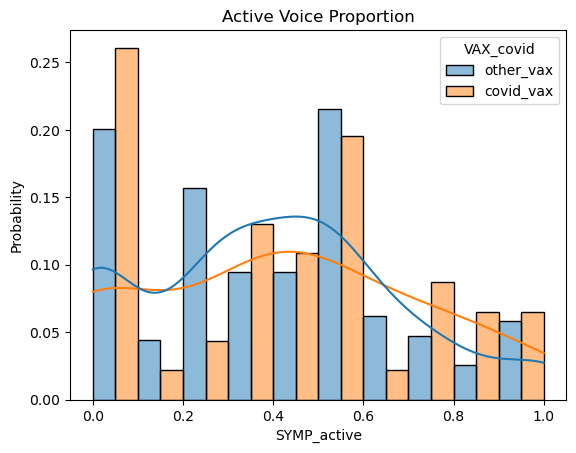

/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/akshaya/anaconda3/envs/vaers/lib/python

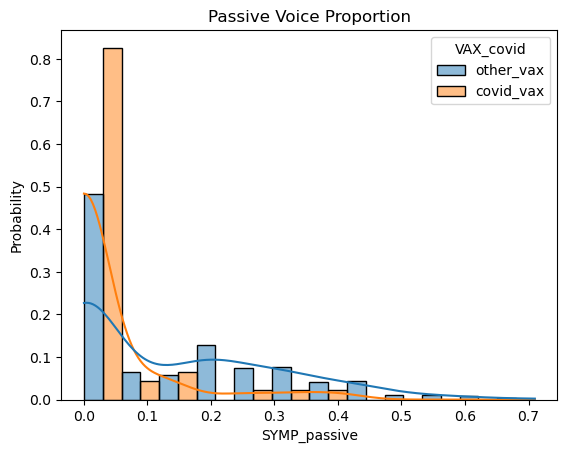

/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/akshaya/anaconda3/envs/vaers/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/akshaya/anaconda3/envs/vaers/lib/python

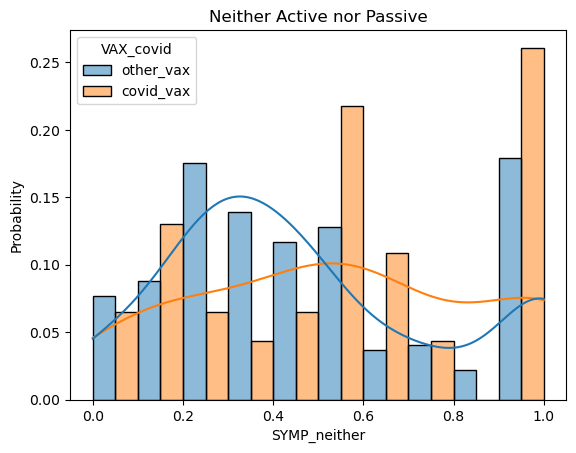

In [27]:
import seaborn as sns
# sns.set_theme()

# sns.histplot(data=df_vaers, x="SYMP_active", hue="VAX_covid", multiple="dodge", shrink=.8)
# sns.violinplot(data = df_vaers.loc[df_vaers["VAX_covid"] == True], x = "SYMP_active")
# x = [10, 20, 30, 40, 50, 60]
# y = [13, 45, 23, 34, 96, 76]
# plt.title('Bar Graph')
# plt.bar(x, y, color='dodgerblue', width=5)
# iris = sns.load_dataset("iris")
# display(iris)
disp_df = df_vaers[["SYMP_active","SYMP_passive","SYMP_neither","VAX_covid"]]
# disp_df = df_vaers[["SYMP_active"]]
# display(disp_df)
plt.figure
sns.histplot(data=disp_df, x="SYMP_active", hue="VAX_covid", \
             stat="probability", \
             common_norm=False,\
            multiple="dodge", \
            kde=True).set_title("Active Voice Proportion")

plt.show()


plt.figure
sns.histplot(data=disp_df, x="SYMP_passive", hue="VAX_covid", \
             stat="probability", \
             common_norm=False,\
            multiple="dodge", \
            kde=True).set_title("Passive Voice Proportion")

plt.show()


plt.figure
sns.histplot(data=disp_df, x="SYMP_neither", hue="VAX_covid", \
             stat="probability", \
             common_norm=False,\
            multiple="dodge", \
            kde=True).set_title("Neither Active nor Passive")

plt.show()


In [28]:
# Histogram values
pmf_active_covid, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="covid_vax"]["SYMP_active"], density=False)
pmf_active_covid = pmf_active_covid/ float(np.sum(pmf_active_covid))
print(pmf_active_covid)

pmf_active_other, b_edges = np.histogram(disp_df.loc[disp_df["VAX_covid"]=="other_vax"]["SYMP_active"], density=False)
pmf_active_other = pmf_active_other/ float(np.sum(pmf_active_other))
print(pmf_active_other)


[0.26086957 0.02173913 0.04347826 0.13043478 0.10869565 0.19565217
 0.02173913 0.08695652 0.06521739 0.06521739]
[0.20072993 0.04379562 0.15693431 0.09489051 0.09489051 0.21532847
 0.0620438  0.04744526 0.02554745 0.05839416]


In [29]:

def kl(p, q):
    """Kullback-Leibler divergence D(P || Q) for discrete distributions
    Parameters
    ----------
    p, q : array-like, dtype=float, shape=n
    Discrete probability distributions.
    """
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [30]:
print(kl(pmf_active_covid, pmf_active_other))
print(kl(pmf_active_other, pmf_active_covid))

0.13305369910525175
0.16299070762074447


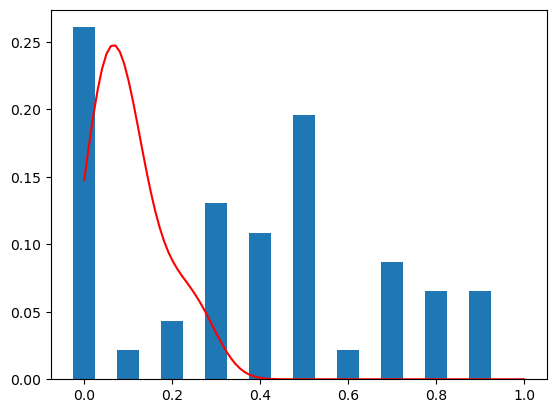

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.26086957 0.02173913 0.04347826 0.13043478 0.10869565 0.19565217
 0.02173913 0.08695652 0.06521739 0.06521739]


In [31]:
from scipy import stats
kde = stats.gaussian_kde(pmf_active_covid, bw_method="silverman")
xx = np.linspace(0, 1, 100)

# fig, ax = plt.subplots(figsize=(8,6))
plt.figure()
plt.bar(np.arange(0,1.0,0.1), pmf_active_covid, width = 0.05)
plt.plot(xx, kde(xx)/20.0, 'r')
plt.show()

print(np.arange(0,1.0,0.1))
print(pmf_active_covid)
